In [437]:
!pip install yfinance vaderSentiment requests matplotlib scikit-learn keras tensorflow pandas numpy datetime

In [438]:
!pip install feedparser

In [439]:
# import statements
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import feedparser

In [440]:
# Config
days_to_fetch = 30
max_articles_per_day = 3
all_articles = []
analyzer = SentimentIntensityAnalyzer()

for i in range(days_to_fetch):
    day = datetime.today() - timedelta(days=i)
    date_str = day.strftime('%Y-%m-%d')

    # Google News RSS URL (NVIDIA news from i days ago)
    url = f"https://news.google.com/rss/search?q=nvidia+when:{i+1}d&hl=en&gl=US&ceid=US:en"
    feed = feedparser.parse(url)
    entries = feed.entries[:max_articles_per_day]

    for entry in entries:
        title = entry.get('title', '')
        desc = entry.get('summary', '')
        combined = f"{title}. {desc}"

        sentiment = analyzer.polarity_scores(combined)['compound']
        all_articles.append((date_str, title, desc, sentiment))

# Create DataFrame
news_df = pd.DataFrame(all_articles, columns=['Date', 'Headline', 'Description', 'Sentiment'])
news_df['Date'] = pd.to_datetime(news_df['Date'])

# Daily average sentiment
daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().to_frame()

# ✅ Print result
print("✅ Google News sentiment collected for", len(daily_sentiment), "days")
print(daily_sentiment.head())

✅ Google News sentiment collected for 29 days
            Sentiment
Date                 
2025-03-13  -0.034233
2025-03-14  -0.034233
2025-03-16  -0.034233
2025-03-17  -0.034233
2025-03-18  -0.034233


/var/folders/4b/_szh68hs7bl2l4fqcctll4bw0000gp/T/ipykernel_50449/2515728870.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


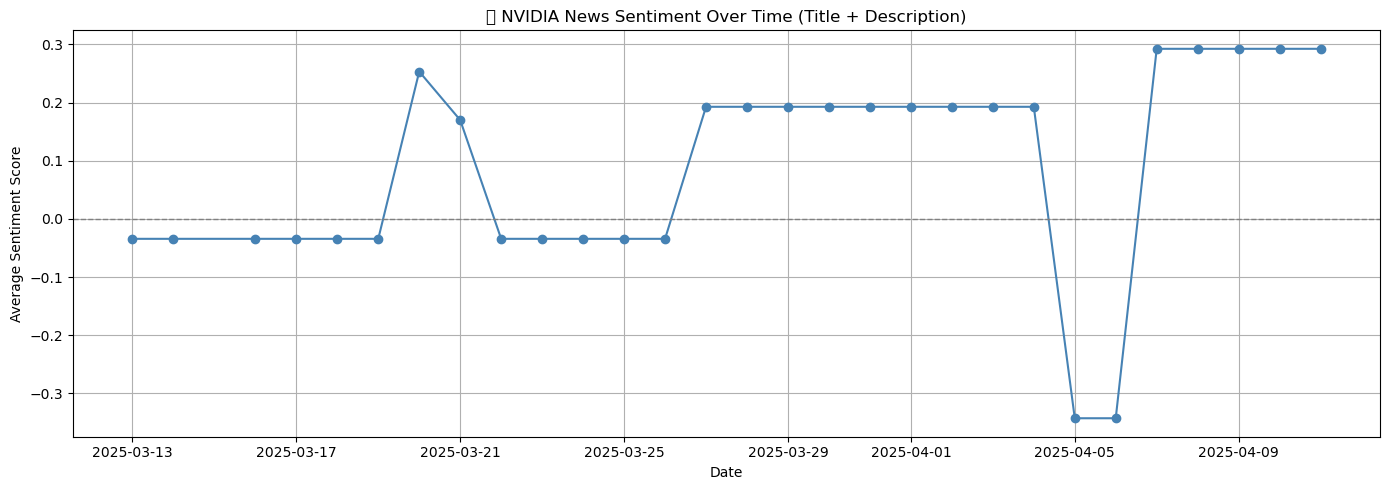

In [441]:
plt.figure(figsize=(14, 5))
plt.plot(daily_sentiment.index, daily_sentiment['Sentiment'], marker='o', linestyle='-', color='steelblue')
plt.title("📊 NVIDIA News Sentiment Over Time (Title + Description)")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [442]:
print(news_df.sort_values('Date').groupby('Date').head(3)[['Date', 'Headline', 'Sentiment']])

         Date                                           Headline  Sentiment
86 2025-03-13  Nintendo Switch 2 Leveled Up With NVIDIA AI-Po...     0.0000
85 2025-03-13  GTC 2025 – Announcements and Live Updates - NV...     0.0000
84 2025-03-13  Trump administration backs off Nvidia's 'H20' ...    -0.1027
81 2025-03-14  Trump administration backs off Nvidia's 'H20' ...    -0.1027
83 2025-03-14  Nintendo Switch 2 Leveled Up With NVIDIA AI-Po...     0.0000
..        ...                                                ...        ...
4  2025-04-10  Nvidia Cleared To Sell H20 AI Chips To China A...     0.1027
3  2025-04-10  Nvidia Is Sinking Today. Is It Time to Buy the...     0.7744
2  2025-04-11  Nvidia Stock Could Fall If 145% China Tariff D...     0.0000
1  2025-04-11  Nvidia Cleared To Sell H20 AI Chips To China A...     0.1027
0  2025-04-11  Nvidia Is Sinking Today. Is It Time to Buy the...     0.7744

[87 rows x 3 columns]


In [443]:
# Step 1: Download NVIDIA stock data
end_date = datetime.today()
start_date = end_date - timedelta(days=3*365)  # 3 years of data
nvidia_data = yf.download('NVDA', start=start_date, end=end_date)

# Check and flatten MultiIndex
# Flatten MultiIndex columns from yfinance
if isinstance(nvidia_data.columns, pd.MultiIndex):
    nvidia_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in nvidia_data.columns]

[*********************100%***********************]  1 of 1 completed


In [444]:
nvidia_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

In [445]:
nvidia_data.describe()

,Close,High,Low,Open,Volume
count,752.000000,752.000000,752.000000,752.000000,7.520000e+02
mean,63.388033,64.619890,62.057540,63.411094,4.434351e+08
std,45.555390,46.481678,44.615427,45.679847,1.714821e+08
min,11.214938,11.722394,10.801383,10.959213,1.051570e+08
25%,19.551001,19.982336,18.902014,19.427375,3.241200e+08
50%,45.942814,46.724394,45.134081,46.042184,4.314805e+08
75%,111.734959,115.368056,109.209242,112.429982,5.328105e+08
max,149.416245,153.115916,147.806407,153.015919,1.543911e+09


In [446]:
nvidia_data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-04-04,94.309998,100.129997,92.110001,98.910004,532273800
2025-04-07,97.639999,101.750000,86.620003,87.459999,611041300
2025-04-08,96.300003,105.849998,94.459999,103.809998,476243400
2025-04-09,114.330002,115.099998,97.529999,98.889999,612918300
2025-04-10,107.570000,110.860001,99.150002,109.320000,432498057


In [447]:
nvidia_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 752 entries, 2022-04-12 to 2025-04-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   752 non-null    float64
 1   High    752 non-null    float64
 2   Low     752 non-null    float64
 3   Open    752 non-null    float64
 4   Volume  752 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.2 KB


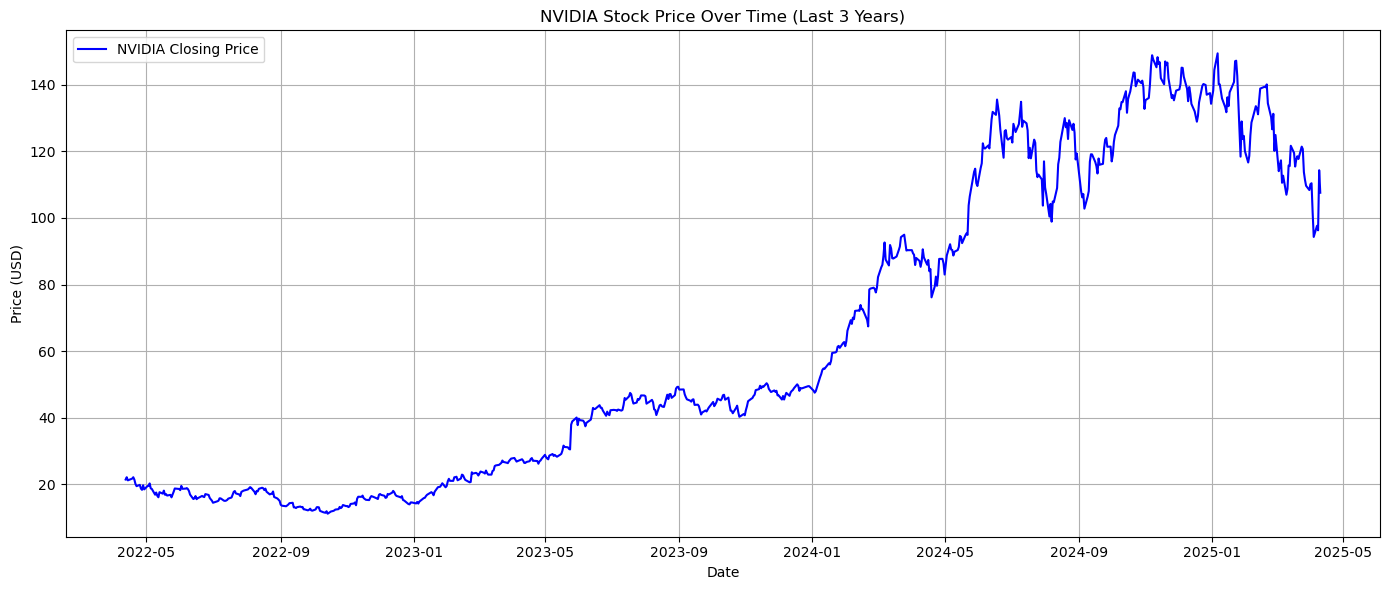

In [448]:
plt.figure(figsize=(14, 6))
plt.plot(nvidia_data.index, nvidia_data["Close"], label="NVIDIA Closing Price", color="blue")
plt.title("NVIDIA Stock Price Over Time (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [449]:
nvidia_data.index = pd.to_datetime(nvidia_data.index)
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

# Make sure column name is correct
daily_sentiment.columns = ['Sentiment']

# Drop any existing 'Sentiment' column
if 'Sentiment' in nvidia_data.columns:
    nvidia_data = nvidia_data.drop(columns='Sentiment')

# Merge cleanly
nvidia_data = nvidia_data.merge(daily_sentiment, left_index=True, right_index=True, how='left')
nvidia_data['Sentiment'] = nvidia_data['Sentiment'].ffill()

# Verify
print(nvidia_data[['Close', 'Sentiment']].tail())

                 Close  Sentiment
Date                             
2025-04-04   94.309998   0.192700
2025-04-07   97.639999   0.292367
2025-04-08   96.300003   0.292367
2025-04-09  114.330002   0.292367
2025-04-10  107.570000   0.292367


In [450]:
nvidia_data['DayOfWeek'] = nvidia_data.index.dayofweek  # 0 = Monday
nvidia_data['Month'] = nvidia_data.index.month

In [451]:
# Step 1: Only fill missing sentiment (leave prices as-is)
nvidia_data['Sentiment'] = nvidia_data['Sentiment'].ffill().bfill()

# Step 2: Then extract features (drop rows only if any price data is missing — optional)
data = nvidia_data[feature_cols]

# Optional safety: drop rows where essential price columns are NaN
data = data.dropna(subset=['Close', 'Volume'])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Rebuild sequences
def create_sequences(data, sequence_length=90):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x_all, y_all = create_sequences(scaled_data, sequence_length)

In [452]:
nvidia_data.head()

,Close,High,Low,Open,Volume,Sentiment,DayOfWeek,Month
Date,,,,,,,,
2022-04-12,21.469976,22.689045,21.248328,22.501343,662258000,-0.034233,1,4
2022-04-13,22.167873,22.464404,21.421058,21.693626,516943000,-0.034233,2,4
2022-04-14,21.224371,22.740969,21.129522,22.469398,569097000,-0.034233,3,4
2022-04-18,21.748537,22.053053,21.045650,21.166459,525701000,-0.034233,0,4
2022-04-19,22.162880,22.337602,21.280278,21.685636,512781000,-0.034233,1,4


In [453]:
print("x_all shape:", x_all.shape)
print("y_all shape:", y_all.shape)

x_all shape: (692, 60, 5)
y_all shape: (692,)


In [454]:
print(data.head())
print(data.shape)

                Close     Volume  Sentiment  DayOfWeek  Month
Date                                                         
2022-04-12  21.469976  662258000  -0.034233          1      4
2022-04-13  22.167873  516943000  -0.034233          2      4
2022-04-14  21.224371  569097000  -0.034233          3      4
2022-04-18  21.748537  525701000  -0.034233          0      4
2022-04-19  22.162880  512781000  -0.034233          1      4
(752, 5)


In [455]:
# Split for training/testing
split = int(0.8 * len(x_all))
x_train, x_test = x_all[:split], x_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [456]:
print("x_train shape:", x_train.shape)

x_train shape: (553, 60, 5)


In [457]:
# Define Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',    # Watch validation loss
    patience=5,            # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Go back to best-performing weights
)


In [458]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(
    x_train, y_train,
    validation_split=0.1,     # 10% of training data for validation
    epochs=100,               # Let it go up to 100 epochs
    batch_size=32,
    callbacks=[early_stop],   # Plug in early stopping
    verbose=1
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0282 - val_loss: 0.0072
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0164
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 0.0057
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 0.0096
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0069
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 0.0078
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - val_loss: 0.0072
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

In [462]:
predicted = model.predict(x_test)

# Only need to inverse scale 'Close' (first feature)
predicted_prices = scaler.inverse_transform(
    np.hstack((predicted, np.zeros((predicted.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]

actual_prices = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [464]:
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

print(f"📊 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"🔍 R² Score: {r2:.4f}")

📊 MAE: 7.09
📉 RMSE: 8.90
🔍 R² Score: 0.4867


Test dates shape: (139,)
Actual prices shape: (139,)


/var/folders/4b/_szh68hs7bl2l4fqcctll4bw0000gp/T/ipykernel_50449/2818849279.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


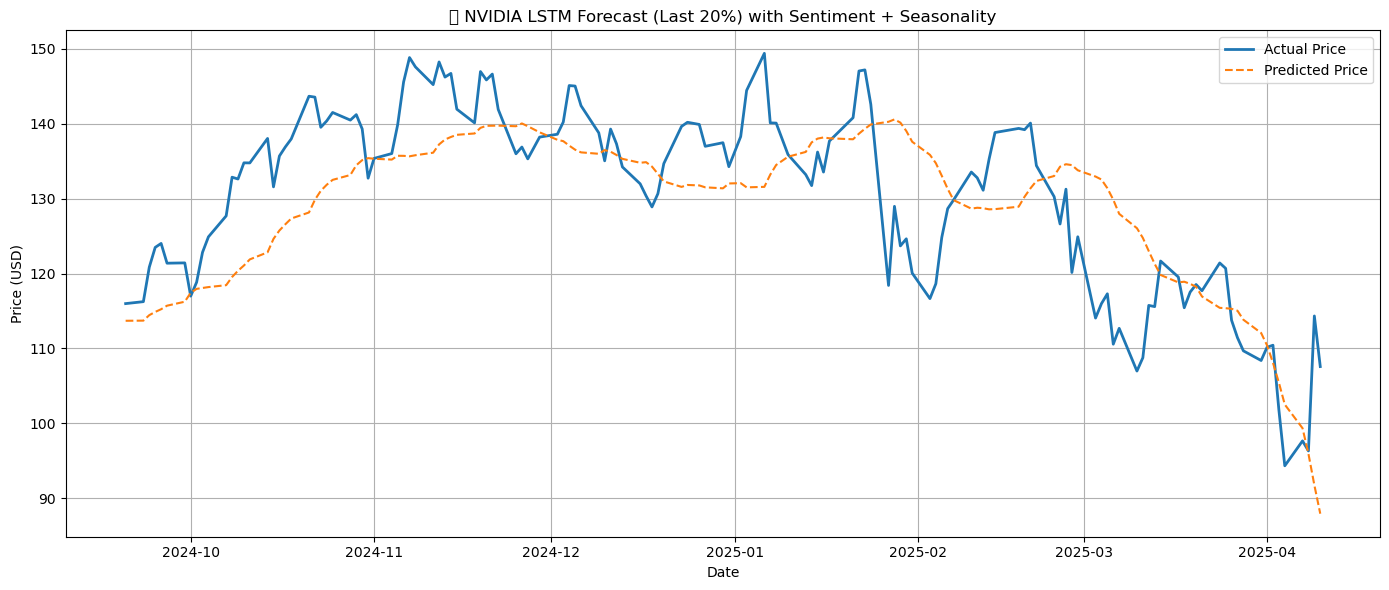

In [466]:
# ✅ Get the full list of original dates from your preprocessed `data`
original_dates = data.index

# ✅ Get the test dates (align with y_test after sequence + split)
test_dates = original_dates[sequence_length + split:]

# ✅ Make sure they match
print("Test dates shape:", test_dates.shape)
print("Actual prices shape:", actual_prices.shape)

plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual_prices, label='Actual Price', linewidth=2)
plt.plot(test_dates, predicted_prices, label='Predicted Price', linestyle='--')
plt.title("📈 NVIDIA LSTM Forecast (Last 20%) with Sentiment + Seasonality")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [468]:
# Get the real full list of dates
all_dates = data.index[sequence_length:]  # aligned with y_all

In [470]:
all_actual = scaler.inverse_transform(
    np.hstack((y_all.reshape(-1, 1), np.zeros((y_all.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]

In [472]:
# Place predictions into correct spot
predicted_full = np.empty_like(all_actual)
predicted_full[:] = np.nan
predicted_full[split:] = predicted_prices  # Place predictions in last 20% range

/var/folders/4b/_szh68hs7bl2l4fqcctll4bw0000gp/T/ipykernel_50449/2924940195.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


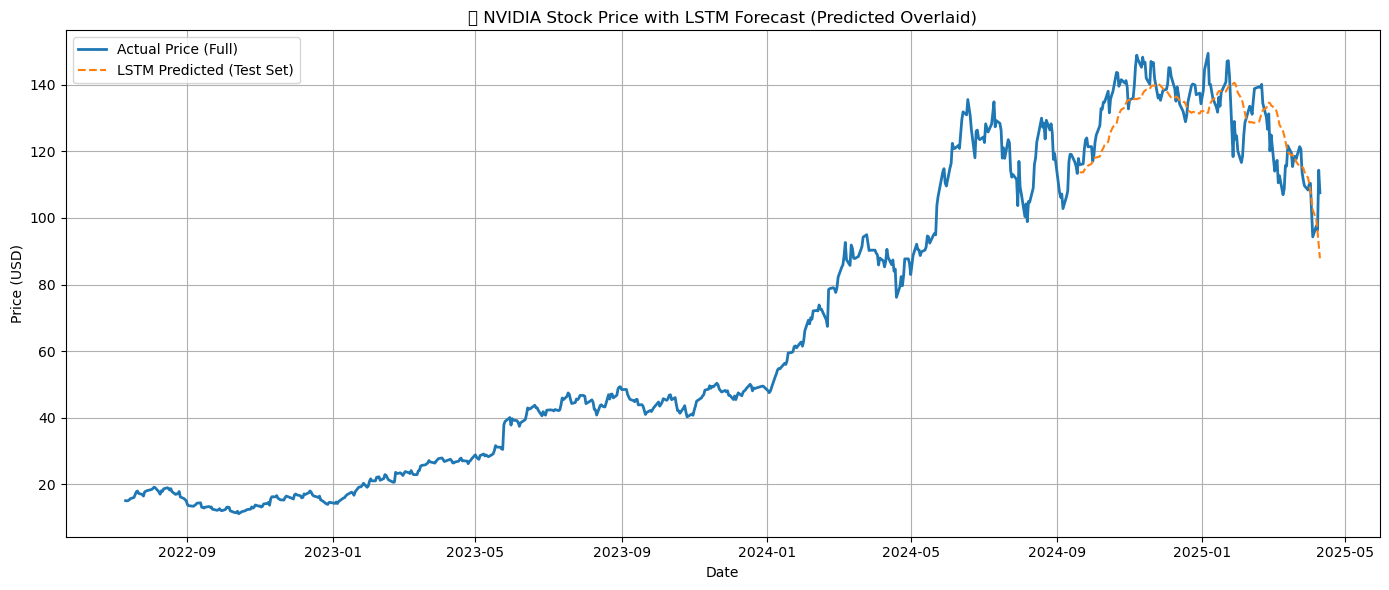

In [474]:
plt.figure(figsize=(14, 6))
plt.plot(all_dates, all_actual, label='Actual Price (Full)', linewidth=2)
plt.plot(all_dates, predicted_full, label='LSTM Predicted (Test Set)', linestyle='--')
plt.title("📈 NVIDIA Stock Price with LSTM Forecast (Predicted Overlaid)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [476]:
residuals = actual_prices - predicted_prices

/var/folders/4b/_szh68hs7bl2l4fqcctll4bw0000gp/T/ipykernel_50449/1653851012.py:8: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


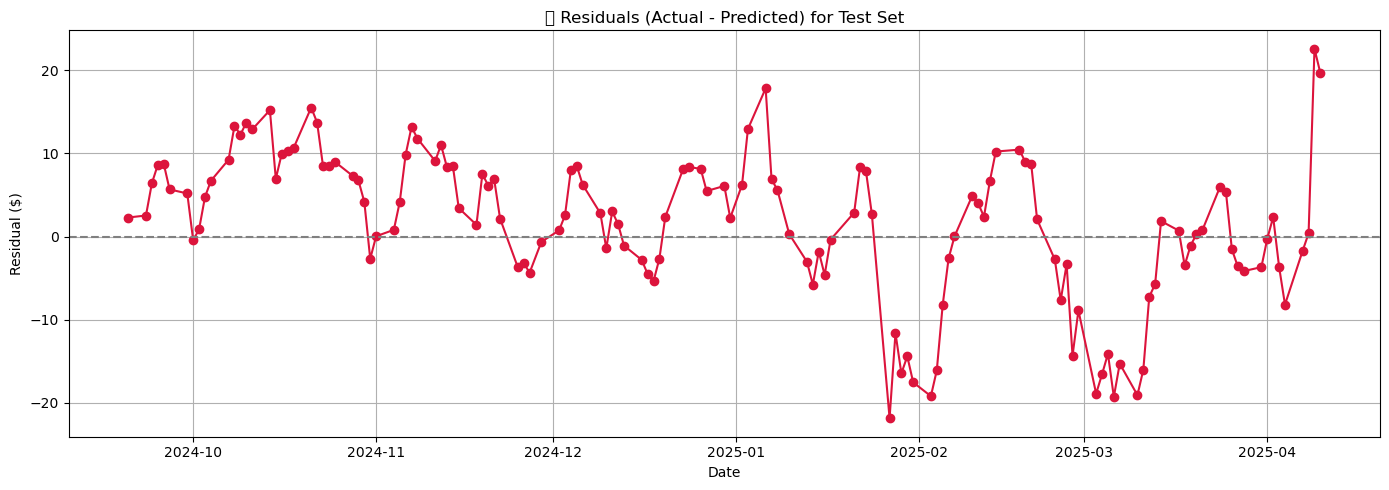

In [478]:
plt.figure(figsize=(14, 5))
plt.plot(test_dates, residuals, marker='o', linestyle='-', color='crimson')
plt.axhline(0, color='gray', linestyle='--')
plt.title("🔍 Residuals (Actual - Predicted) for Test Set")
plt.xlabel("Date")
plt.ylabel("Residual ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/4b/_szh68hs7bl2l4fqcctll4bw0000gp/T/ipykernel_50449/3143685176.py:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


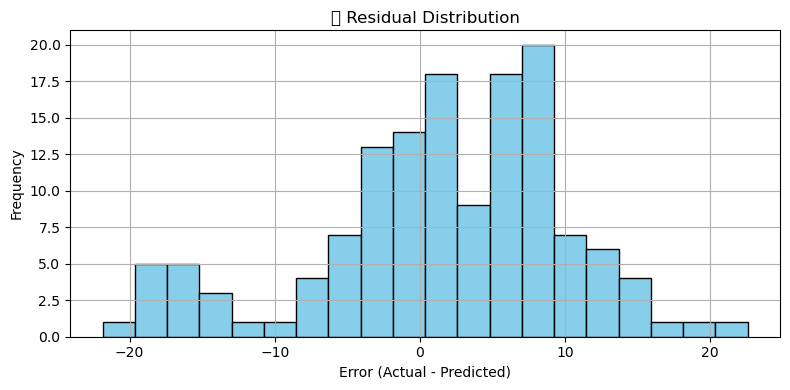

In [480]:
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title("📊 Residual Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()